# Lab 2: Probability, Statistics & Significance in Bioinformatics

This notebook follows the 90-minute lab exercises: from sampling and t-tests to BH FDR, bootstrapping, and a short Bayesian demo. The notebook will attempt to download a small RNA-seq dataset from GEO; if that fails (no internet / package), it will simulate a dataset.

**Environment:** Python, `numpy`, `pandas`, `scipy`, `statsmodels`, `matplotlib`, `seaborn`.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(8,5)})
np.random.seed(42)

print('Libraries imported. numpy, pandas, scipy, statsmodels, matplotlib, seaborn')

Libraries imported. numpy, pandas, scipy, statsmodels, matplotlib, seaborn


In [2]:
# Try to fetch GEO dataset; fallback to simulated if unavailable
use_real = False
try:
    import GEOparse
    print('GEOparse available. Attempting to download a small dataset (this may fail if no internet).')
    gse_id = 'GSE10072'
    try:
        gse = GEOparse.get_GEO(geo=gse_id, destdir='.')
        
        # Try to get expression data from the correct location
        if hasattr(gse, 'pivot_samples') and callable(gse.pivot_samples):
            try:
                expr_table = gse.pivot_samples('VALUE')
                if expr_table is not None and not expr_table.empty:
                    use_real = True
                    print(f'Loaded expression table from {gse_id} (shape: {expr_table.shape})')
                else:
                    print('Expression table is empty; will fallback to simulation.')
            except Exception as pivot_e:
                print(f'Failed to pivot samples: {pivot_e}')
                # Try alternative method - access through samples
                if hasattr(gse, 'samples') and gse.samples:
                    sample_data = []
                    sample_names = []
                    for sample_id, sample in gse.samples.items():
                        if hasattr(sample, 'table') and sample.table is not None:
                            sample_data.append(sample.table['VALUE'].values)
                            sample_names.append(sample_id)
                    
                    if sample_data:
                        expr_table = pd.DataFrame(sample_data).T
                        expr_table.columns = sample_names
                        use_real = True
                        print(f'Loaded expression table from {gse_id} via samples (shape: {expr_table.shape})')
                    else:
                        print('No expression data found in samples; will fallback to simulation.')
                else:
                    print('No samples found; will fallback to simulation.')
        else:
            print('GSE object does not have pivot_samples method; will fallback to simulation.')
    except Exception as e:
        print('Failed to download or parse GEO series:', e)
except Exception as e:
    print('GEOparse not available or import failed:', e)

if not use_real:
    print('Falling back to simulated RNA-seq-like dataset (Negative Binomial counts).')
    n_genes = 100
    n_ctrl = 3
    n_treat = 3
    mu = np.random.gamma(shape=2.0, scale=10.0, size=n_genes)
    dispersion = 0.2
    counts_ctrl = np.vstack([np.random.negative_binomial(n=1/dispersion, p=(1/(1+mu[i]*dispersion)), size=n_ctrl)
                              for i in range(n_genes)])
    mu_treat = mu.copy()
    de_genes = np.random.choice(n_genes, size=10, replace=False)
    mu_treat[de_genes[:5]] *= 3.0
    mu_treat[de_genes[5:]] *= 0.4
    counts_treat = np.vstack([np.random.negative_binomial(n=1/dispersion, p=(1/(1+mu_treat[i]*dispersion)), size=n_treat)
                               for i in range(n_genes)])
    counts = np.hstack([counts_ctrl, counts_treat]).astype(int)
    sample_labels = ['ctrl1','ctrl2','ctrl3','trt1','trt2','trt3']
    expr_df = pd.DataFrame(counts, columns=sample_labels)
    expr_df.index = [f'gene_{i+1}' for i in range(n_genes)]
    print('Simulated count matrix shape:', expr_df.shape)
    expr_df.head()
else:
    # Process real GEO data
    print('Using real GEO data. Processing expression matrix...')
    # Clean up the data - remove any non-numeric columns and handle missing values
    expr_df = expr_table.select_dtypes(include=[np.number])
    expr_df = expr_df.fillna(0)  # Fill missing values with 0
    
    # If we have too many genes, subsample for computational efficiency
    if expr_df.shape[0] > 1000:
        print(f'Subsampling from {expr_df.shape[0]} to 1000 genes for efficiency')
        expr_df = expr_df.sample(n=1000, random_state=42)
    
    # Create artificial treatment groups for demonstration
    # In real analysis, you would use the actual sample metadata
    n_samples = expr_df.shape[1]
    n_ctrl = n_samples // 2
    n_treat = n_samples - n_ctrl
    
    # Rename columns to match the expected format
    ctrl_cols = expr_df.columns[:n_ctrl]
    treat_cols = expr_df.columns[n_ctrl:n_ctrl+n_treat]
    
    # Rename columns for consistency with the rest of the notebook
    new_cols = ['ctrl' + str(i+1) for i in range(n_ctrl)] + ['trt' + str(i+1) for i in range(n_treat)]
    expr_df.columns = new_cols
    
    print(f'Real data matrix shape: {expr_df.shape}')
    print('Sample groups:', new_cols)
    expr_df.head()

09-Oct-2025 10:47:34 DEBUG utils - Directory . already exists. Skipping.
09-Oct-2025 10:47:34 INFO GEOparse - File already exist: using local version.
09-Oct-2025 10:47:34 INFO GEOparse - Parsing ./GSE10072_family.soft.gz: 
09-Oct-2025 10:47:34 DEBUG GEOparse - DATABASE: GeoMiame
09-Oct-2025 10:47:34 DEBUG GEOparse - SERIES: GSE10072
09-Oct-2025 10:47:34 DEBUG GEOparse - PLATFORM: GPL96


GEOparse available. Attempting to download a small dataset (this may fail if no internet).


09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254625
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254626
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254627
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254628
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254629
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254630
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254631
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254632
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254633
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254634
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254635
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254636
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254637
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254638
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254639
09-Oct-2025 10:47:35 DEBUG GEOparse - SAMPLE: GSM254640
09-Oct-2025 10:47:36 DEBUG GEOparse - SAMPLE: GSM254641
09-Oct-2025 10:47:36 DEBUG GEOparse - SAMPLE: GS

Loaded expression table from GSE10072 (shape: (22283, 107))
Using real GEO data. Processing expression matrix...
Subsampling from 22283 to 1000 genes for efficiency
Real data matrix shape: (1000, 107)
Sample groups: ['ctrl1', 'ctrl2', 'ctrl3', 'ctrl4', 'ctrl5', 'ctrl6', 'ctrl7', 'ctrl8', 'ctrl9', 'ctrl10', 'ctrl11', 'ctrl12', 'ctrl13', 'ctrl14', 'ctrl15', 'ctrl16', 'ctrl17', 'ctrl18', 'ctrl19', 'ctrl20', 'ctrl21', 'ctrl22', 'ctrl23', 'ctrl24', 'ctrl25', 'ctrl26', 'ctrl27', 'ctrl28', 'ctrl29', 'ctrl30', 'ctrl31', 'ctrl32', 'ctrl33', 'ctrl34', 'ctrl35', 'ctrl36', 'ctrl37', 'ctrl38', 'ctrl39', 'ctrl40', 'ctrl41', 'ctrl42', 'ctrl43', 'ctrl44', 'ctrl45', 'ctrl46', 'ctrl47', 'ctrl48', 'ctrl49', 'ctrl50', 'ctrl51', 'ctrl52', 'ctrl53', 'trt1', 'trt2', 'trt3', 'trt4', 'trt5', 'trt6', 'trt7', 'trt8', 'trt9', 'trt10', 'trt11', 'trt12', 'trt13', 'trt14', 'trt15', 'trt16', 'trt17', 'trt18', 'trt19', 'trt20', 'trt21', 'trt22', 'trt23', 'trt24', 'trt25', 'trt26', 'trt27', 'trt28', 'trt29', 'trt30', '

## Exercise 0 — Setup & Warm-up

Explore the dataset: view head, summary statistics, and plot histogram of expression for one gene.

Expression matrix shape: (1000, 107)


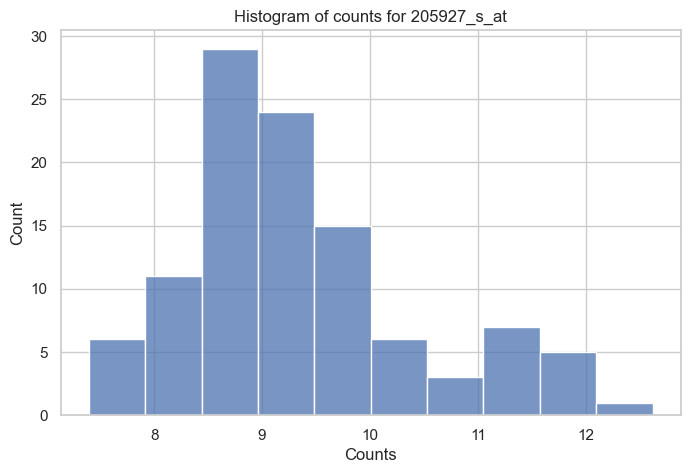

In [14]:
print('Expression matrix shape:', expr_df.shape)
expr_df.head()

expr_df.describe().T.head()

# Plot histogram of a single gene
gene = expr_df.index[0]
sns.histplot(expr_df.loc[gene, :], bins=10, kde=False)
plt.title(f'Histogram of counts for {gene}')
plt.xlabel('Counts')
plt.show()

In [16]:
expr_df.head()

,ctrl1,ctrl2,ctrl3,ctrl4,ctrl5,ctrl6,ctrl7,ctrl8,ctrl9,ctrl10,...,trt45,trt46,trt47,trt48,trt49,trt50,trt51,trt52,trt53,trt54
ID_REF,,,,,,,,,,,,,,,,,,,,,
205927_s_at,10.115352,8.915092,8.059204,8.667864,8.436176,8.617522,9.447690,11.761084,11.658402,9.598857,...,7.568188,7.599906,8.683320,8.801817,11.082751,9.499696,8.933923,8.456788,8.344605,8.727552
207309_at,7.218072,7.569389,8.178327,7.838868,7.807056,7.859845,8.079654,7.797132,8.094036,8.189827,...,8.228592,7.746684,7.747841,8.179274,7.504791,7.438956,7.528672,7.706032,7.458940,7.906974
208208_at,4.879273,4.908413,5.093420,4.914261,4.949664,4.977687,5.076461,4.940149,5.186511,5.081773,...,5.060512,5.140546,5.352178,5.266863,4.905902,5.405533,5.010151,5.209753,5.284070,5.329719
210033_s_at,7.488069,6.133655,6.264189,6.444648,6.770031,6.637981,6.399477,6.340911,6.848442,6.702418,...,6.362172,9.731498,7.545384,6.654173,7.217247,6.807212,7.219287,6.995689,6.655232,6.738843
212243_at,8.064218,8.310257,7.904353,8.365413,8.222464,8.395939,8.262747,8.218549,7.994974,8.222668,...,8.028720,8.178443,8.004897,7.784609,7.814420,8.108878,7.710486,7.907375,8.060201,8.347325


In [17]:
expr_df.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
ctrl1,1000.0,7.451551,1.898242,3.909932,6.036466,7.360639,8.763799,14.435633
ctrl2,1000.0,7.462274,1.855217,3.924957,6.111106,7.358285,8.652506,14.708283
ctrl3,1000.0,7.516418,1.723607,4.051356,6.333764,7.479364,8.625444,14.333058
ctrl4,1000.0,7.470837,1.807138,3.987337,6.212538,7.408608,8.617182,14.524692
ctrl5,1000.0,7.461981,1.785505,4.015102,6.249959,7.378701,8.604136,14.663578


## Exercise 1 — Probability & Sampling

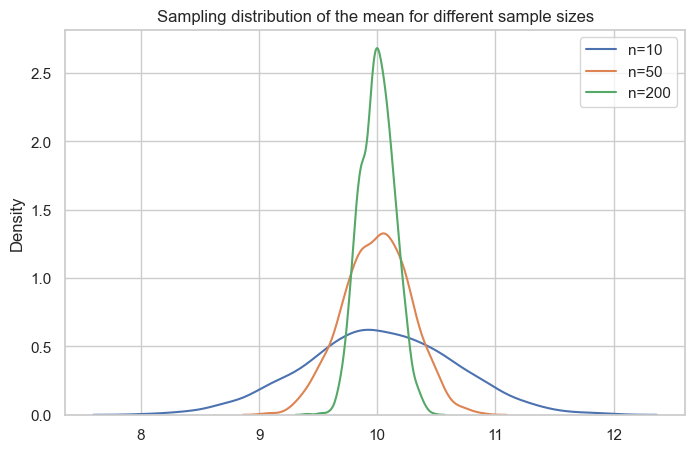

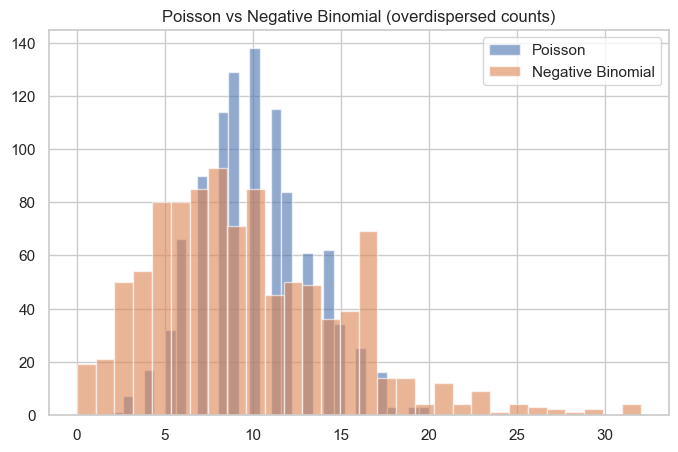

In [4]:
pop = np.random.normal(loc=10, scale=2, size=100000)
for n in [10,50,200]:
    means = [np.mean(np.random.choice(pop, size=n, replace=True)) for _ in range(2000)]
    sns.kdeplot(means, label=f'n={n}')
plt.legend()
plt.title('Sampling distribution of the mean for different sample sizes')
plt.show()

# Compare Poisson and NB
lam = 10
pois = np.random.poisson(lam, size=1000)
nb = np.random.negative_binomial(n=1/0.2, p=(1/(1+lam*0.2)), size=1000)
plt.hist(pois, bins=30, alpha=0.6, label='Poisson')
plt.hist(nb, bins=30, alpha=0.6, label='Negative Binomial')
plt.legend(); plt.title('Poisson vs Negative Binomial (overdispersed counts)'); plt.show()

## Exercise 2 — Hypothesis Testing: t-test

Gene: 205927_s_at, t-stat=1.728, p-value=0.0871


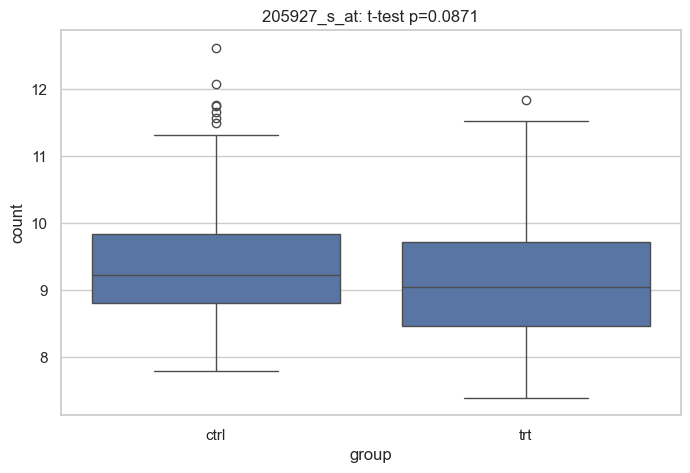

In [5]:
gene = expr_df.index[0]
ctrl = expr_df.loc[gene, expr_df.columns.str.contains('ctrl')]
trt = expr_df.loc[gene, expr_df.columns.str.contains('trt')]
tstat, pval = stats.ttest_ind(ctrl, trt, equal_var=False)
print(f'Gene: {gene}, t-stat={tstat:.3f}, p-value={pval:.3g}')

# boxplot
import pandas as pd
data = pd.DataFrame({'count': np.concatenate([ctrl.values, trt.values]),
                     'group': ['ctrl']*len(ctrl) + ['trt']*len(trt)})
sns.boxplot(x='group', y='count', data=data)
plt.title(f"{gene}: t-test p={pval:.3g}")
plt.show()

## Exercise 3 — ANOVA

ANOVA F-stat=22.637, p-value=5.81e-08


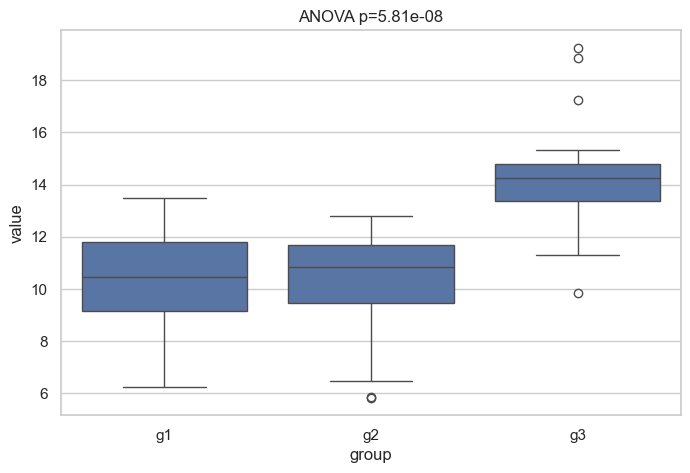

In [6]:
g1 = np.random.normal(10,2,20)
g2 = np.random.normal(11,2,20)
g3 = np.random.normal(14,2,20)
fstat, pval_anova = stats.f_oneway(g1,g2,g3)
print(f'ANOVA F-stat={fstat:.3f}, p-value={pval_anova:.3g}')

df_anova = pd.DataFrame({'value': np.concatenate([g1,g2,g3]),
                         'group': ['g1']*len(g1) + ['g2']*len(g2) + ['g3']*len(g3)})
sns.boxplot(x='group', y='value', data=df_anova)
plt.title(f"ANOVA p={pval_anova:.3g}")
plt.show()

## Exercise 4 — Multiple Testing & FDR

Raw significant (p<0.05): 104 / 1000
BH-significant (FDR<0.05): 0
5e-05


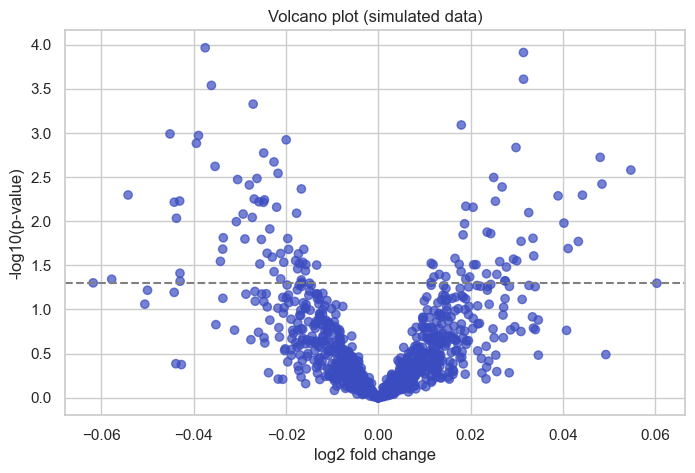

In [21]:
pvals = []
log2fc = []
for g in expr_df.index:
    a = expr_df.loc[g, expr_df.columns.str.contains('ctrl')].values
    b = expr_df.loc[g, expr_df.columns.str.contains('trt')].values
    t, p = stats.ttest_ind(a, b, equal_var=False)
    pvals.append(p if not np.isnan(p) else 1.0)
    log2fc.append(np.log2((b.mean()+1)/(a.mean()+1)))

pvals = np.array(pvals)
log2fc = np.array(log2fc)
rej, pvals_corrected, alphacSidak, alphacBonf = multipletests(pvals, alpha=0.05, method='fdr_bh')
print(f"Raw significant (p<0.05): {(pvals<0.05).sum()} / {len(pvals)}")
print(f"BH-significant (FDR<0.05): {rej.sum()}")

plt.scatter(log2fc, -np.log10(pvals+1e-12), c=rej, cmap='coolwarm', alpha=0.7)
plt.xlabel('log2 fold change'); plt.ylabel('-log10(p-value)'); plt.title('Volcano plot (simulated data)')
plt.axhline(-np.log10(0.05), linestyle='--', color='grey')
plt.show()

## Exercise 5 — DGE Mini-Analysis

In [22]:
res = pd.DataFrame({'gene': expr_df.index, 'log2FC': log2fc, 'pval': pvals, 'pval_adj': pvals_corrected, 'significant': rej}).set_index('gene').sort_values('pval')
res.head()

,log2FC,pval,pval_adj,significant
gene,,,,
216728_at,-0.037511,0.000108,0.061355,False
203602_s_at,0.031452,0.000123,0.061355,False
217313_at,0.031472,0.000247,0.072400,False
222045_s_at,-0.036171,0.000290,0.072400,False
211736_at,-0.027123,0.000471,0.094286,False


Top upregulated genes:
 []
Top downregulated genes:
 []


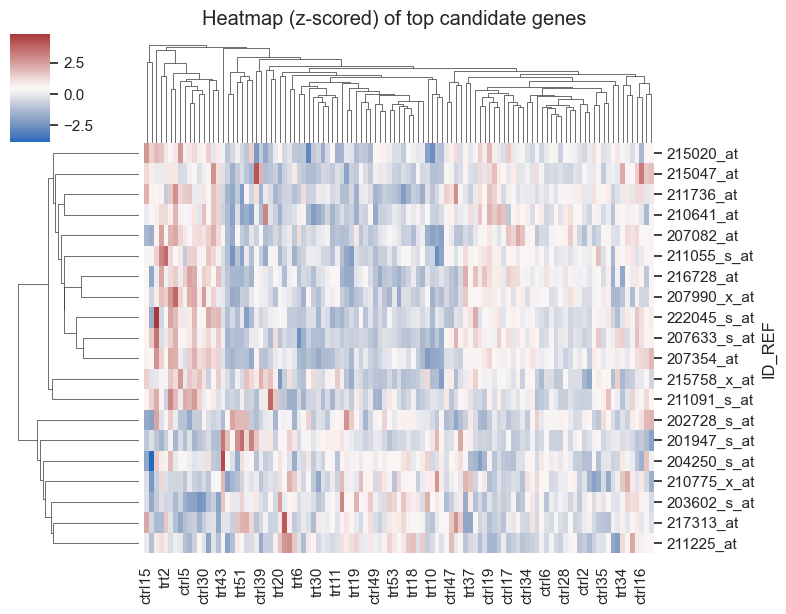

In [23]:
# top genes
try:
    top_up = res[res['significant'] & (res['log2FC']>0)].sort_values('pval').head(10)
    top_down = res[res['significant'] & (res['log2FC']<0)].sort_values('pval').head(10)
    print('Top upregulated genes:\n', top_up.index.tolist())
    print('Top downregulated genes:\n', top_down.index.tolist())
except Exception as e:
    print('Error selecting top genes:', e)

# Heatmap
top_genes = list(res.index[:20])
import seaborn as sns
sns.clustermap(expr_df.loc[top_genes], z_score=0, cmap='vlag', figsize=(8,6))
plt.suptitle('Heatmap (z-scored) of top candidate genes', y=1.02)
plt.show()

## Exercise 6 — Bootstrapping Confidence Intervals

[10.11535152  8.91509209  8.05920371  8.66786402  8.43617559  8.61752221
  9.4476899  11.76108363 11.6584024   9.59885661  9.23263011 12.61980551
  9.32526388  9.47505973  8.90496747  8.69130319  9.33226163  7.8425444
  8.45447353  9.20165144  9.35756475  9.15523214  9.2195207  11.49342428
  8.74556397  9.34467331  9.5345412  11.75122814  8.87323825 10.95450145
  8.83970676  9.84375669 11.19911985  8.16106198  8.64913357  8.66531224
 12.08158199  9.78631077 10.20937277  8.96358783  9.46468787  7.79285284
 10.33778343 11.32010336  8.8248204   9.52536078  8.80878662  8.9788736
  8.76903364 11.56942129  8.94625581  9.42816756  9.10988994  7.39558167
  9.71529317 11.02890285  9.06494106  8.46004299  9.95096947  9.21190619
  9.12155151  8.30494779  9.52577754  9.16842748 10.01538202 11.5319557
  9.73497715  8.3518089   9.65355258  8.92034469 11.18928314  8.20112596
  8.26485206 10.26730265  8.90720196  8.65107474 10.51256964  8.8559702
  9.21433671  8.41510567  9.85290846  9.92984348  8.091

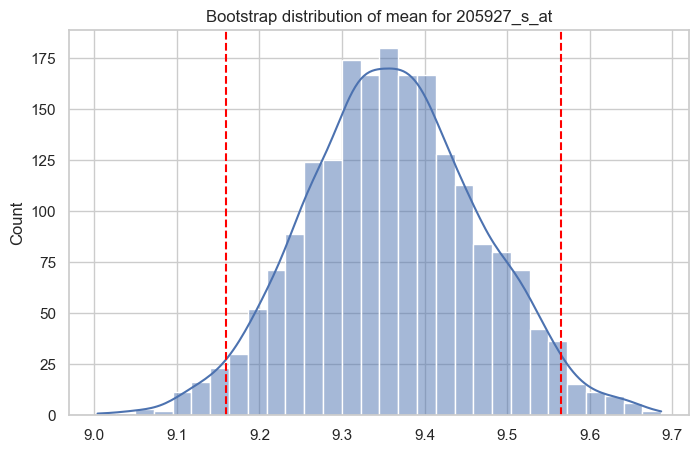

In [24]:
gene = expr_df.index[0]
values = expr_df.loc[gene].values
print(values)
n_boot = 2000
means = [np.mean(np.random.choice(values, size=len(values), replace=True)) for _ in range(n_boot)]
ci = np.percentile(means, [2.5,97.5])
print(f'Bootstrap 95% CI for mean of {gene}: {ci}')

sns.histplot(means, bins=30, kde=True)
plt.axvline(ci[0], color='red', linestyle='--'); plt.axvline(ci[1], color='red', linestyle='--')
plt.title(f'Bootstrap distribution of mean for {gene}'); plt.show()

## Exercise 7 — Bayesian Inference Basics (Simple Demo)

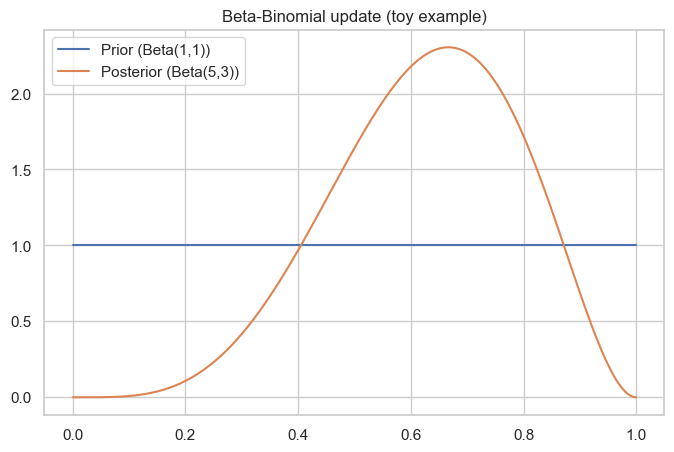

Posterior mean estimate of probability: 0.625


In [10]:
from scipy.stats import beta
alpha_prior, beta_prior = 1, 1
successes = 4
trials = 6
alpha_post = alpha_prior + successes
beta_post = beta_prior + (trials - successes)
x = np.linspace(0,1,200)
prior = beta.pdf(x, alpha_prior, beta_prior)
posterior = beta.pdf(x, alpha_post, beta_post)
plt.plot(x, prior, label='Prior (Beta(1,1))')
plt.plot(x, posterior, label=f'Posterior (Beta({alpha_post},{beta_post}))')
plt.legend(); plt.title('Beta-Binomial update (toy example)'); plt.show()
print(f'Posterior mean estimate of probability: {alpha_post/(alpha_post+beta_post):.3f}')

## Exercise 8 — Model Confidence in ML (Optional)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = expr_df.T.mean(axis=1).values.reshape(-1,1)
y = np.array([0]*3 + [1]*3)
accs = []
for _ in range(200):
    idx = np.random.choice(len(y), size=len(y), replace=True)
    Xb, yb = X[idx], y[idx]
    clf = LogisticRegression().fit(Xb, yb)
    preds = clf.predict(Xb)
    accs.append(accuracy_score(yb, preds))
np.percentile(accs, [2.5,50,97.5])

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)